<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


    
# 30_BasicLinearRegression

#### Demonstrate linear regression, Lasso regularization for feature selection, and posterior predictive checks

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)
    + [Prepare Dataset](#Prepare-Dataset)


+ [Linear Regression (OLS)](#Linear-Regression-[OLS])
    + [Frequentist OLS Regression](#Frequentist-OLS-Regression)
    + [Bayesian OLS Regression](#Bayesian-OLS-Regression)
        + [Define and Run Model](#Define-and-run-model)
        + [View Feature Coefficients](#View-feature-coefficients)
        + [View Traceplots](#View-Traceplots)
        + [View Autocorrelation Plots](#View-Autocorrelation-Plots)
        + [View Correlation Plots](#View-Correlation-Plots)


+ [Lasso L1 Regularized Regression](#Lasso-L1-Regularized-Regression)
    + [Frequentist Lasso Regression](#Frequentist-Lasso-Regression)
    + [Bayesian Lasso Regression](#Bayesian-Lasso-Regression)


+ [Ridge L2 Regularized Regression](#Ridge-L2-Regularized-Regression)
    + [Frequentist Ridge Regression](#Frequentist-Ridge-Regression)
    + [Bayesian Ridge Regression](#Bayesian-Ridge-Regression)


+ [Naive Model Comparison](#Naive-Model-Comparison)
    + [Posterior Predictive Checks](#Posterior-Predictive-Checks)
    + [Deviance Information Criterion [DIC]](#Deviance-Information-Criterion-[DIC])


---

# Setup

In [34]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [17]:
# general packages
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed
from io import StringIO
from collections import OrderedDict
from itertools import combinations

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
from scipy.stats import norm, laplace, ks_2samp
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import RidgeCV
from sklearn.manifold import TSNE
import statsmodels.api as sm

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
from hack_findmap import find_MAP

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

## Local Functions

In [25]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


def trace_median(x):
    return pd.Series(np.median(x,0), name='median')


def plot_traces(trcs, retain=1000, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''
    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
    ax = pm.traceplot(trcs[-retain:], varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs[-retain:],varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs[-retain:], varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    


## Load Data

In [4]:
cnxsql = sqlite3.connect('data/car_emissions.db')
df = pd.read_sql('select * from cars', cnxsql, index_col=None)

In [5]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw','mfr_is_vw','is_tdi']:
    df[ft] = df[ft].astype(bool)

In [6]:
custom_describe(df)

(2646, 18)


,2607,1653,835,count,mean,std,min,25%,50%,75%,max,dtype
mfr,volvo,mercedes-benz,bmw,2646,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,"v60, my16","c-class saloon, model year 2015",7 series f01/f02,2646,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
desc,d4,"c 220 bluetec with 18"" rear wheels",730d saloon,2646,NaN,NaN,'1 air,NaN,NaN,NaN,zc 1.6,object
fuel_type,diesel,diesel,diesel,2646,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
metric_combined,4.4,4.1,5.6,2646,5.65,1.87,3.1,4.4,5.1,6.30,16,float64
metric_extra_urban,3.9,3.6,5.1,2646,4.85,2.35,0,4.0,4.5,5.30,107,float64
metric_urban_cold,5.3,4.9,6.5,2646,7.10,3.00,0,5.2,6.2,8.10,24.7,float64
engine_capacity,1969,2143,2993,2646,2072.58,903.62,395,1560.0,1984.0,1999.00,6752,float64
emissions_co_mgkm,203,278,223,2646,268.34,140.71,30,162.0,243.0,341.75,913,float64
emissions_nox_mgkm,19,62,46,2646,37.38,18.63,1,23.0,35.0,52.00,158,float64


## Prepare Dataset

This dataset allows us to ask if there's any interesting patterns in NOx emissions: for cars made by the Volkswagen group

+ `emissions_nox_mgkm`

... according to a handful of exogenous variables:

+ `mfr_owner_is_vw, transmission, fuel_type_smpl, is_tdi`
+ `engine_capacity, metric_combined, metric_extra_urban, metric_urban_cold`


##### Declare feats for use

In [6]:
fts_cat = ['parent_is_vw', 'mfr_is_vw', 'parent', 'mfr', 'trans', 'fuel_type', 'is_tdi']
fts_cat_smp = ['mfr_is_vw','trans','fuel_type','is_tdi']
fts_num = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
           ,'engine_capacity', 'emissions_co_mgkm']
fts_num_smp = ['metric_combined', 'engine_capacity', 'emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

### Apply exclusions 
To make analysis a little easier:
1. remove extreme outliers in the endogenous feat (cheating)
2. Remove hybrids

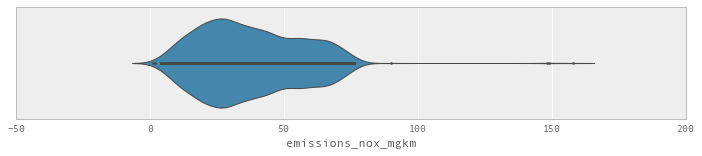

In [7]:
f, ax1d = plt.subplots(1,1,figsize=(12,2))
_ = sns.violinplot(x=ft_endog, data=df, ax=ax1d, inner='point')

In [8]:
df.loc[df[ft_endog]>80]

,mfr,model,desc,fuel_type,metric_combined,metric_extra_urban,metric_urban_cold,engine_capacity,emissions_co_mgkm,emissions_nox_mgkm,particulates_no_mgkm,thc_nox_emissions_mgkm,thc_emissions_mgkm,trans,is_tdi,parent,mfr_is_vw,parent_is_vw
1744,mercedes-benz,"e-class estate, model year 2015",e 250 with 17'' rear wheels,petrol,5.5,5.0,6.2,1991.0,287.0,90.0,NaN,NaN,62.0,auto,False,daimler-ag,False,False
1751,mercedes-benz,"e-class estate, model year 2016",e 220 bluetec with 18'' & 19'' rear wheels,diesel,5.5,4.8,6.5,2143.0,94.0,148.0,0.2,160.0,NaN,auto,False,daimler-ag,False,False
1752,mercedes-benz,"e-class estate, model year 2016",e 350 bluetec with 18'' & 19'' rear wheels eco...,diesel,4.4,4.4,4.3,2987.0,248.0,158.0,0.2,181.0,NaN,auto,False,daimler-ag,False,False
2056,peugeot,308 cc,1.6 e-hdi 115,diesel,4.8,4.4,5.5,1560.0,216.0,149.0,0.4,184.0,NaN,manual,False,peugeot-citroen,False,False


In [9]:
df = df.loc[(df[ft_endog]<=80) & (df['fuel_type'] != 'hybrid')].copy()
df.shape

(2593, 18)

##### Standardize the dataset according to Gelman 1 / (2 * sd)

Divide by 2 standard deviations in order to put the variance of a normally distributed variable nearer to the variance range of a binary variable. See http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf for more info.

In [10]:
dfs = pd.concat((df[ft_endog], df[fts_cat]
    ,((df[fts_num] - df[fts_num].mean(0)) / (2 * df[fts_num].std(0)))),1)
custom_describe(dfs)

(2593, 13)


,1690,841,765,count,mean,std,min,25%,50%,75%,max,dtype
emissions_nox_mgkm,12,36,32,2593,37.32,17.9,1,23.000000,35.000000,51.000000,76,float64
parent_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
mfr_is_vw,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
parent,daimler-ag,bmw,bmw,2593,NaN,NaN,aston,NaN,NaN,NaN,volksw,object
mfr,mercedes-benz,bmw,bmw,2593,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
trans,auto,semiauto,auto,2593,NaN,NaN,auto,NaN,NaN,NaN,semiau,object
fuel_type,petrol,petrol,petrol,2593,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
is_tdi,False,False,False,2593,NaN,NaN,False,NaN,NaN,NaN,True,bool
metric_combined,-0.0728208,0.80692,0.220426,2593,-0.00,0.5,-0.685973,-0.339409,-0.152797,0.167108,2.75301,float64
metric_extra_urban,-0.0751821,0.47462,0.0728415,2593,0.00,0.5,-0.47696,-0.180913,-0.075182,0.093988,21.5997,float64


## Describe dataset

+ The dataset is 2593 rows, with 12 exog features, 1 endog feature.
+ These are observations of car emissions tests, one row per car.
+ You can read off the basic distributional statistics of the features in the table above. Numeric features have been standardized according to [Gelman's 2sd principle](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf).
+ I have selected these particular 12 features to work with. Some are derivatives of original features.

We have the following features to choose from:

```
+ Categoricals:
    + `trans`     - the car transmission, simplified to 'auto', 'semiauto', 'manual'
    + `fuel_type` - the car power supply, simplified to 'petrol', 'diesel'
    + `parent`    - the parent company of the car manufacturer, 20 values
    + `mfr`       - the car manufacturer, 38 values

+ Booleans:
    + `parent_is_vw` - if the parent company of the car manufacturer is Volkswagen
    + `mfr_is_vw`    - if the car manufacturer is Volkswagen
    + `is_tdi`       - (processed feature) if the car engine type is a turbo diesel
    
+ Numerics:
    + `metric_combined`    - a score for fuel efficiency in combined driving
    + `metric_extra_urban` - a score for fuel efficiency in an extra-urban driving
    + `metric_urban_cold`  - a score for fuel efficiency in an urban setting, cold start
    + `emissions_co_mgkm`  - a count of CO particulates emitted mg/km
    
+ Numeric endogenous feature:
    + `emissions_nox_mgkm` - a count of NOx particulates emitted mg/km    
```

For the purposes of this Notebook, the final feature mentioned `emissions_nox_mgkm` will be used as the _endogenous_ / _dependent_ / _output_ feature of the linear models. All other features may be used as _exogenous_ / _independent_ / _input_ features.

---

---

# Linear Regression with StatsModels

First we'll create an intentionally basic OLS (Ordinary Least Squares) Regression model, to warm up to using PyMC3 and PyStan with real data.


$$\bf{y} \sim \mathcal{N}(\beta^{T} \bf{x},\sigma^{2})$$

<p style="font-size:small;">
... where for datapoint $i \in n$:
<br>$y_{i}$ is a sample from a $\mathcal{N}$ormal distribution defined by
mean $\mu = \beta^{T} x_{i}$ and variance $\sigma^{2}$
</p>


#### Declare full modelspec

In [11]:
fml_all = '{} ~ '.format(ft_endog) + ' + '.join(fts_num_smp + fts_cat_smp)
fml_all

'emissions_nox_mgkm ~ metric_combined + engine_capacity + emissions_co_mgkm + mfr_is_vw + trans + fuel_type + is_tdi'

##### Create design matrices for statsmodels

In [12]:
(mx_en, mx_ex) = pt.dmatrices(fml_all, dfs, return_type='dataframe', NA_action='raise')
custom_describe(mx_ex, 2, )

(2593, 9)


,1771,1039,count,mean,std,min,25%,50%,75%,max,dtype
Intercept,1.000000,1.000000,2593,1.00,0.00,1.000000,1.000000,1.000000,1.000000,1.000000,float64
mfr_is_vw[T.True],0.000000,0.000000,2593,0.04,0.20,0.000000,0.000000,0.000000,0.000000,1.000000,float64
trans[T.manual],0.000000,1.000000,2593,0.49,0.50,0.000000,0.000000,0.000000,1.000000,1.000000,float64
trans[T.semiauto],0.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
fuel_type[T.petrol],0.000000,0.000000,2593,0.50,0.50,0.000000,0.000000,1.000000,1.000000,1.000000,float64
is_tdi[T.True],0.000000,0.000000,2593,0.12,0.32,0.000000,0.000000,0.000000,0.000000,1.000000,float64
metric_combined,-0.312750,-0.472703,2593,-0.00,0.50,-0.685973,-0.339409,-0.152797,0.167108,2.753013,float64
engine_capacity,0.042048,-0.278857,2593,0.00,0.50,-0.920116,-0.278857,-0.045471,-0.037765,2.579014,float64
emissions_co_mgkm,0.099293,-0.421449,2593,0.00,0.50,-0.846545,-0.382482,-0.088458,0.272874,2.281452,float64


## Frequentist OLS Regression

For later comparison, first let's use `statsmodels` to run a Freqentist OLS

In [13]:
smfit = sm.OLS(mx_en, mx_ex).fit()
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:     emissions_nox_mgkm   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     306.4
Date:                Thu, 21 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:43:58   Log-Likelihood:                -10295.
No. Observations:                2593   AIC:                         2.061e+04
Df Residuals:                    2584   BIC:                         2.066e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              46.1078    

**Observe**

+ That was easy! `statsmodels` is great for basic stuff
+ The R-squared of ~0.48 isn't too bad considering the possible range (-inf,1) (NOTE I explain a little more about r-squared theory later on)
+ The condition number of 9.83 below 20, the [recommended theshold](http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html) at which we should consider the effects of multicollinearity

I won't get into the actual interpretation of the coefficient values yet.


**NOTE** 

+ Just in case you missed it, I used `patsy` above to create 'design matrices' for the data, prior to modelling with `statsmodels`. This converted the main dataframe to the same 'modelspec' as I will use throughout the Frequentist and Bayesian modelling.
+ The categorical features have been binarised (a.k.a one-hot encoded) and the `Intercept` coefficient is overloaded with the first value from each categorical feature to allow for proper _identifiability_: i.e:
    + if a datapoint had raw feature value `trans == manual`, that is now indicated by a boolean `True` in the new column `trans[T.manual]`, and a boolean `False` in the new column `trans[T.semiauto]`
    + if a datapoint had raw feature value `trans == auto`, that is now indicated by a boolean `False` in the new columns `trans[T.manual]` and `trans[T.semiauto]`: the `Intercept` column always has value `1` aka `True`, meaning that `trans == auto` is represented by the `Intercept`.
    + The overloading means that the `Intercept` represents cars with categorical values `trans == auto`, `mfr_owner_is_vw == False`, `fuel_type == diesel`, and `is_tdi == False`.
+ Due to our _standardization_ (mean-centering and dividing by the std.dev.) the `Intercept` also represents the mean of the numeric features.

---

# Linear Regression with PyMC3

First, lets look at a few different basic linear regression models

## v1: build model (OLS, full syntax)

In [14]:
with pm.Model() as mdl_ols_longwinded:
    
    # define priors, use Uniform for OLS
    b0 = pm.Uniform('b0_intercept', lower=-1e3, upper=1e3)
    b1a = pm.Uniform('b1a_trans[T.manual]', lower=-1e3, upper=1e3)
    b1b = pm.Uniform('b1b_trans[T.semiauto]', lower=-1e3, upper=1e3)
    b2 = pm.Uniform('b2_fuel_type[T.petrol]', lower=-1e3, upper=1e3)
    b3 = pm.Uniform('b3_is_tdi[T.True]', lower=-1e3, upper=1e3)
    b4 = pm.Uniform('b4_mfr_is_vw[T.True]', lower=-1e3, upper=1e3)
    b5 = pm.Uniform('b5_engine_capacity', lower=-1e3, upper=1e3)
    b6 = pm.Uniform('b6_metric_combined', lower=-1e3, upper=1e3)
    b7 = pm.Uniform('b7_emissions_co_mgkm', lower=-1e3, upper=1e3)
    
    # define linear model
    yest = ( b0 +
             b1a * mx_ex['trans[T.manual]'] +
             b1b * mx_ex['trans[T.semiauto]'] +
             b2 * mx_ex['fuel_type[T.petrol]'] + 
             b3 * mx_ex['is_tdi[T.True]'] +
             b4 * mx_ex['mfr_is_vw[T.True]'] +
             b5 * mx_ex['engine_capacity'] +
             b6 * mx_ex['metric_combined'] +
             b7 * mx_ex['emissions_co_mgkm']) 

    ## Define Normal likelihood with HalfNormal error
    epsilon = pm.HalfCauchy('epsilon', 10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=epsilon, observed=mx_en[ft_endog])
    

Applied interval-transform to b0_intercept and added transformed b0_intercept_interval to model.
Applied interval-transform to b1a_trans[T.manual] and added transformed b1a_trans[T.manual]_interval to model.
Applied interval-transform to b1b_trans[T.semiauto] and added transformed b1b_trans[T.semiauto]_interval to model.
Applied interval-transform to b2_fuel_type[T.petrol] and added transformed b2_fuel_type[T.petrol]_interval to model.
Applied interval-transform to b3_is_tdi[T.True] and added transformed b3_is_tdi[T.True]_interval to model.
Applied interval-transform to b4_mfr_is_vw[T.True] and added transformed b4_mfr_is_vw[T.True]_interval to model.
Applied interval-transform to b5_engine_capacity and added transformed b5_engine_capacity_interval to model.
Applied interval-transform to b6_metric_combined and added transformed b6_metric_combined_interval to model.
Applied interval-transform to b7_emissions_co_mgkm and added transformed b7_emissions_co_mgkm_interval to model.
Applied l

## v2: build model (OLS, using glm submodule)

+ syntactic sugar!
+ Force betas to Uniform (for OLS)
+ Likelihood is Normal (with default HalfCauchy for error prior)

In [15]:
with pm.Model() as mdl_ols:
      
    pm.glm.glm(fml_all,
               dfs,
               intercept_prior=pm.Uniform.dist(lower=-1e3, upper=1e3),
               regressor_prior=pm.Uniform.dist(lower=-1e3, upper=1e3),
               family=pm.glm.families.Normal())

Applied interval-transform to Intercept and added transformed Intercept_interval to model.
Applied interval-transform to mfr_is_vw[T.True] and added transformed mfr_is_vw[T.True]_interval to model.
Applied interval-transform to trans[T.manual] and added transformed trans[T.manual]_interval to model.
Applied interval-transform to trans[T.semiauto] and added transformed trans[T.semiauto]_interval to model.
Applied interval-transform to fuel_type[T.petrol] and added transformed fuel_type[T.petrol]_interval to model.
Applied interval-transform to is_tdi[T.True] and added transformed is_tdi[T.True]_interval to model.
Applied interval-transform to metric_combined and added transformed metric_combined_interval to model.
Applied interval-transform to engine_capacity and added transformed engine_capacity_interval to model.
Applied interval-transform to emissions_co_mgkm and added transformed emissions_co_mgkm_interval to model.
Applied log-transform to sd and added transformed sd_log to model.


## v3: build model (Ridge Regression, glm default settings)

+ Normal priors and likelihood

In [22]:
with pm.Model() as mdl_ridge:
      
    pm.glm.glm(fml_all, dfs)

Applied log-transform to sd and added transformed sd_log to model.


Recap OLS:


$$\bf{y} \sim \mathcal{N}(\beta^{T} \bf{x},\sigma^{2})$$

<p style="font-size:small;">
... where for datapoint $i \in n$:
<br>$y_{i}$ is a sample from a $\mathcal{N}$ormal distribution defined by
mean $\mu = \beta^{T} x_{i}$ and variance $\sigma^{2}$
</p>

$$\sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)x_{i}^{T} = 0$$

$$\beta_{MLE} = (X^{T}X)^{-1}X^{T}y$$


##### Ridge (L2 regularisation)

Add new parameter $\lambda$ to constrain the sum of squared values of $\beta$

$$\beta_{MLE} = \overset{argmin}{\beta} = \frac{1}{2} \; \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum_{i=1}^{n} \left(\beta_{i} \right)^{2}$$

Possible to create closed form:

$$\beta_{MLE} = (\lambda I + X^{T}X)^{-1}X^{T}y$$

## Note: I've skipped right over Lasso

I blogged about it earlier in the year: http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

##### Lasso (L1 regularization)

Or more generally, we would solve using a numerical optimization, allowing for complicated MLE fitting including penalties on the cost function.


Set parameter $\lambda$ to constrain the sum of absolute values of \beta

$$\beta_{MLE} = \overset{argmin}{\beta} = \frac{1}{2} \; \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda \sum_{i=1}^{n} \left|\beta_{i} \right|$$

Solutions are non-linear in $y_{i}$ so there's no closed form

## v4: build model (Robust Regression, glm using StudentT likelihood)

+ Normal priors (so Ridge Regression L2 reg)
+ StudentT likelihood

In [46]:
with pm.Model() as mdl_robust:
      
    pm.glm.glm(fml_all,
               dfs,
               family=pm.glm.families.StudentT())

Applied log-transform to lam and added transformed lam_log to model.


## Okay, lets get on with it and use v4

##### Take samples using NUTS

In [47]:
with mdl_robust:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)

    ## take samples
    trc_robust = pm.sample(2000, start=start_MAP, njobs=1, step=pm.NUTS())

 [-----------------100%-----------------] 2000 of 2000 complete in 35.3 sec

##### View traceplots (full trace)

Rather than just get point-estimate statistics from the traces, let's take a look at the traceplots using PyMC3's built-in `pm.traceplot()` function.

+ each feature coefficient is shown on a single row
+ the right-hand-side plot is a simple timeseries of each value on the trace over selected samples
+ the left-hand-side plot is a density plot of the traces (mean shown in red) this is a marginal posterior distribution on each coefficient

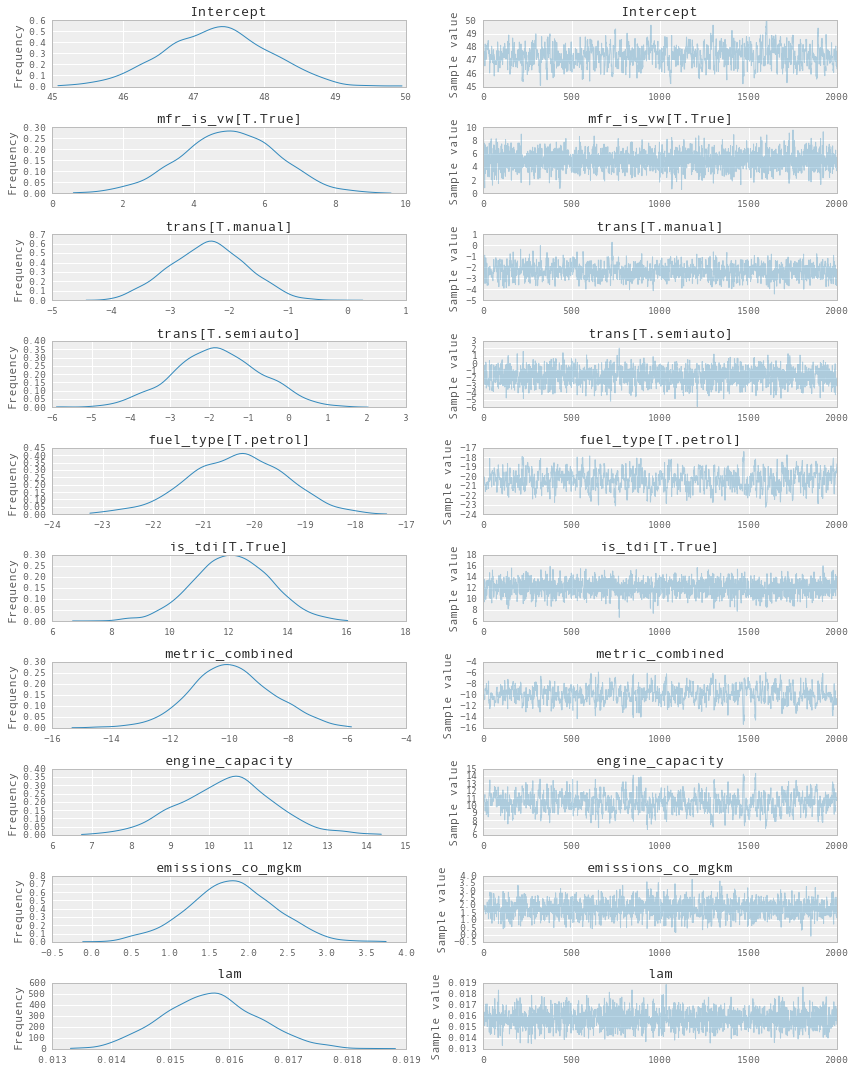

In [48]:
rvs_robust = [rv.name for rv in strip_derived_rvs(mdl_robust.unobserved_RVs)]
_ = pm.traceplot(trc_robust[:], varnames=rvs_robust, figsize=(12, len(rvs_robust)*1.5))

##### View traceplots (post burnin)

/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


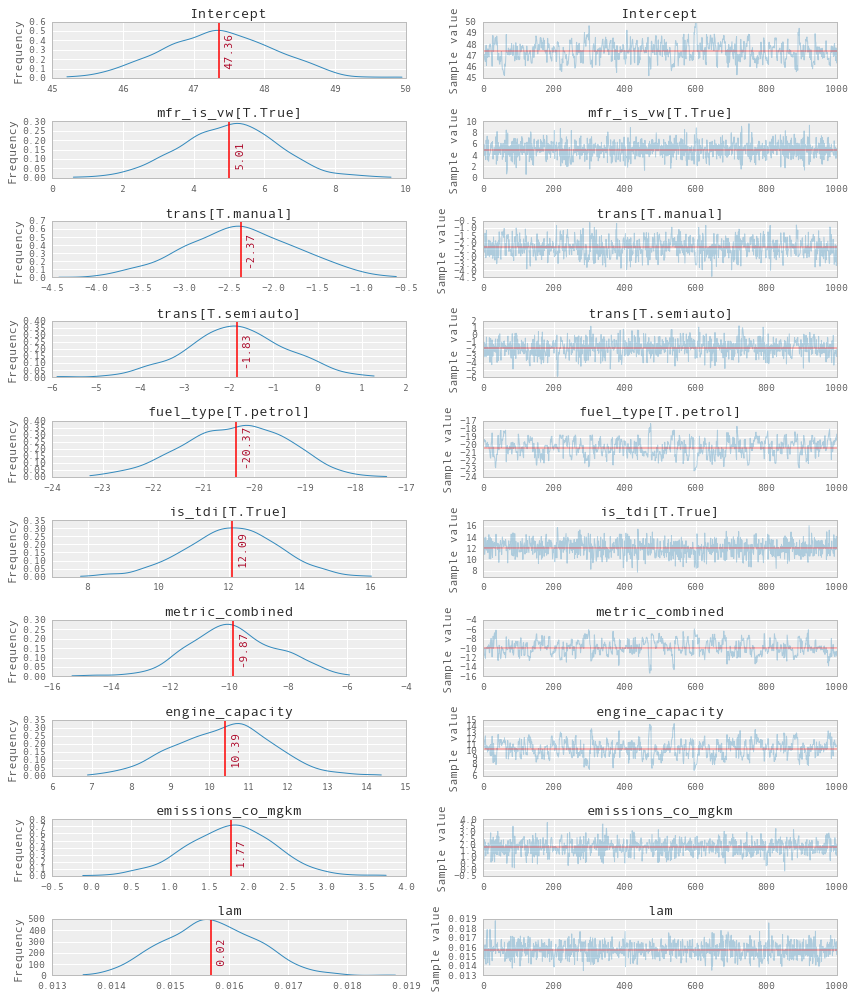

In [49]:
plot_traces(trc_robust[-1000:], varnames=rvs_robust)

##### View feature coefficients

**Observe**

+ Most of the co-efficients have a bell-shaped curve for the marginal posterior distribution (particularly the Intercept for example), this indicates:
    + the coefficients have settled to a single value in a symmetirc distribution with some variance
    + the coefficients do not display multi-modalities which would indicate we have mis-specified the model
    + we could perhaps try a new model using bell-shaped priors for each of the coefficients and get better performance: a Gaussian with large variance would probably be a good place to start.
+ Similarly, most of the timeseries traceplots show a 'hairy caterpillar' form, where all values, both inlying and extreme, occur frequently but at irregular intervals throughout the trace. This indicates the markov sampler chain was 'well-mixed', taking samples evenly from the area surrounding the optimal position


##### View coeffs in a table

In [50]:
print(pm.df_summary(trc_robust[-1000:], varnames=rvs_robust))

                          mean        sd  mc_error    hpd_2.5   hpd_97.5
Intercept            47.363270  0.785315  0.047696  45.862503  48.816634
mfr_is_vw[T.True]     5.006325  1.381110  0.039431   2.228824   7.547745
trans[T.manual]      -2.369376  0.628125  0.024973  -3.637767  -1.191247
trans[T.semiauto]    -1.830070  1.120119  0.040445  -3.978410   0.234281
fuel_type[T.petrol] -20.365526  1.010785  0.065178 -22.344050 -18.480843
is_tdi[T.True]       12.085647  1.293341  0.045362   9.634010  14.677319
metric_combined      -9.865814  1.504505  0.096916 -12.473207  -6.891343
engine_capacity      10.393548  1.250635  0.078978   7.801777  12.662627
emissions_co_mgkm     1.771210  0.552411  0.018877   0.584400   2.765160
lam                   0.015699  0.000790  0.000026   0.014253   0.017230


/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


**Observe:**
    
+ The above table summarises the final 1000 steps of the traces, giving us the basic statistics of the distributions of the parameter estimates.
+ You can see the mean values are very similar to the `statsmodels` OLS model, which is good to see, and for reference they shown in the following cell:

### View Autocorrelation Plots

Following from our observations above, lets look at the _autocorrelation_ of the traces 

i.e. at timestep $t$, is the position of the trace correlated with _it's own_ lagged position at a previous timestep $t-n$, for $n \in [t,0]$

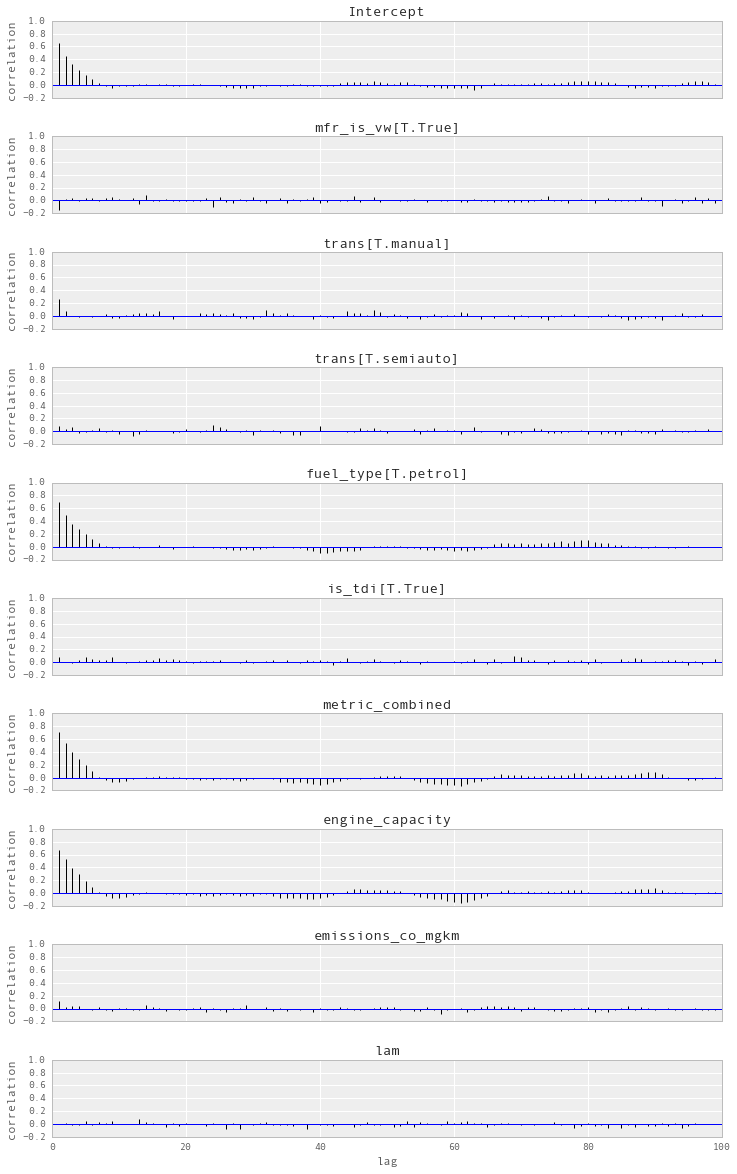

In [51]:
ax = pm.autocorrplot(trc_robust[-1000:], varnames=rvs_robust)

---

---

## What next?

So far, I've only used linear least-squares models with some regularization. This is fine for demonstration, but realistically we ought to try:

1. polynomial regression: allowing the regression line more freedom
2. robust regression: using e.g. a Student-T distribution to better handle outliers
3. outlier detection: using e.g. exotic mixed likelihood functions and more degrees of freedom to identify particular datapoints as outliers.

I won't undertake those particular points here, but you can find them elsewhere:

+ For point (1) above: I've submitted a notebook to the PyMC3 examples folder, showing [model evaluation and polynomial regression](http://pymc-devs.github.io/pymc3/GLM-model-selection/)
+ For points (2) and (3) above: I've submitted another notebook to the PyMC3 examples folder, showing [robust regession and outlier detection](http://pymc-devs.github.io/pymc3/GLM-robust-with-outlier-detection/)

**What I _will_ do here is some brief model evaluation using DIC, MSE and Posterior Predictive Checks.**

---

---

# Naive Model Evaluations

We created 3 different models above: an OLS, a Lasso, and a Ridge Regression.
    
Just to show what's possible with PyMC3, I'll try to evaluate them using some fairly standard (and happily quite built-in) tools.

For more information on Model Selection in PyMC3, and about DIC and WAIC, you could start with:
+ Thomas Wiecki's [detailed response](https://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3/166383#166383) to a question on Cross Validated
+ The Deviance Information Criterion: 12 Years On ([Speigelhalter et al 2014](http://onlinelibrary.wiley.com/doi/10.1111/rssb.12062/abstract))
+ A Widely Applicable Bayesian Information Criterion ([Watanabe 2013](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf))
+ Efficient Implementation of Leave-One-Out Cross-Validation and WAIC for Evaluating Fitted Bayesian Models ([Gelman et al 2015](http://arxiv.org/abs/1507.04544))

## Deviance Information Criterion (DIC)

The [Deviance Information Criterion](https://en.wikipedia.org/wiki/Deviance_information_criterion) (DIC) is a fairly unsophisticated method for comparing the deviance of likelihood across the sample traces of a model run. 

However, this simplicity apparently yields quite good results in a variety of cases, see the discussion worth reading in ([Speigelhalter et al 2014](http://onlinelibrary.wiley.com/doi/10.1111/rssb.12062/abstract))

DIC has recently been added to PyMC3, so lets see what it tells us about our model fits. Lower numbers are better

In [ ]:
# OLS
pm.stats.dic(model=mdl_ols, trace=trc_ols[-1000:])

In [ ]:
# Lasso
pm.stats.dic(model=mdl_lasso, trace=trc_lasso[-7000::7])

In [ ]:
# Ridge
pm.stats.dic(model=mdl_ridge, trace=trc_ridge[-1000:])

**Observe:**

+ All 3 values are quite similar! 
+ Interestingly, the Lasso has the highest (worst) DIC value, probably because I deliberately chose a suboptimal regularization parameter $\lambda$ in order to favour the dropping of feature coefficients. This likely resulted in an _underfitted_ model.

## Posterior Predictive Checks (PPC)

The PPC is another model diagnostic we can easily use in PyMC3:

1. For each datapoint (which naturally has a real value $y$), compute a vector of posterior predicted values $\bf{\hat{y}}$, using each value in the traces, using the model likelihood.
2. Now you have a range of posterior predictions for each datapoint, which you can leave as a distribution or take summary statistics
    1. If we take the mean summary statistic, then we can compute the **mean-squared-error (MSE)**
    2. If we leave as a distribution, then we can compute 1d distributional differences such as the Kolmogorov–Smirnov test or Kullback–Leibler divergence.

### Mean Squared Error (MSE)

Here I use the `sample_ppc()` function to:

+ subsample 500 traces from the 1000 burned-in traces
+ use each of the 500 subsampled trace values to create a model according to the model parameters
+ and generate 50 samples of $\hat{y}$ for each datapoint
+ thereby getting 25,000 estimates of $\hat{y}$ for each of the 2644 datapoints
+ this is probably overkill
+ but very quick to compute, so let's propogate the probability within the model...
+ then I compute the MSE $\frac{1}{n}\sum_{i=1}^{i=n}(\hat{y}_{i}-y_{i})^{2}$ 

In [ ]:
def compute_ppc(trc, mdl, samples=500, size=50):
    return pm.sample_ppc(trc_ols[-1000:], samples=500, model=mdl_ols, size=50)

def compute_mse(df, ppc, ft_endog):
    return np.sum((ppc['y'].mean(0).mean(0).T - df[[ft_endog]])**2)[0]/df.shape[0]

In [ ]:
ppc_ols = compute_ppc(trc_ols[-1000:], mdl_ols, 500, 50)
ppc_lasso = compute_ppc(trc_lasso[-7000::7], mdl_lasso, 500, 50)
ppc_ridge = compute_ppc(trc_ridge[-1000:], mdl_ridge, 500, 50)

In [ ]:
df_mse = pd.DataFrame({'method':['OLS','Lasso','Ridge'], 'mse':np.zeros(3)})
df_mse.set_index('method', inplace=True)

for method, ppc in zip(['OLS','Lasso','Ridge'],[ppc_ols, ppc_lasso, ppc_ridge]):
    df_mse.loc[method,'mse'] = compute_mse(dfs, ppc, ft_endog)

In [ ]:
df_mse

**Observe:**

+ The MSE for the models is extremely close: the Lasso and Ridge values are nearly identical and both represent about 99.92% of larger OLS value.

### R-squared

Since we have MSE anyway, lets calculate the (unadjusted) r-squared ($R^{2}$) value for each model. It's a ratio of the sum of squared errors for the model and the sum of squared errors for a hypothetical model that just predicts the mean of the dataset. 

$$R^{2} = 1 - \frac{\sum e_{model}^{2}}{\sum e_{mean}^{2}}$$

Ideally the $R^{2}$ lives in the range $[0,1]$, but in practice, it's quite easy for a model to perform arbitrily worse than the mean guess, particularly for oddly shaped data, resulting in a possible range (-inf, 1]



In [ ]:
def compute_r2(df, ppc, ft_endog):
    
    sse_model = np.sum((ppc['y'].mean(0).mean(0).T - df[[ft_endog]])**2)[0]
    sse_mean = np.sum((df[[ft_endog]] - df[ft_endog].mean())**2)[0]
    
    return 1 - (sse_model / sse_mean)

In [ ]:
for method, ppc in zip(['OLS','Lasso','Ridge'],[ppc_ols, ppc_lasso, ppc_ridge]):
    df_mse.loc[method,'r2'] = compute_r2(dfs, ppc, ft_endog)

In [ ]:
df_mse

**Observe:**

+ Well, this ought not to be surprising given the MSE result: the $R^{2}$ results are nearly identical
+ the $R^{2}$ for the OLS model is _marginally_ worse then the Lasso and the Ridge

### Distributional Check: Kolmogorov–Smirnov (KS) test

Mean values / MLEs are a clumsy way to summarise data, wasting lots of rich information present in our carefully gathered Bayesian samples.

Instead of summarising to calcuate MSE and $R^{2}$, lets compare the distributions of the predicted values $\hat{y}$ vs the actual values $y$

I'll use the [Kolmogorov-Smirnov (KS) Test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test), specifically the 2-sample version, which lets us quantify the distance between the empirical distribution functions of two 'samples': the model predictions in this case.

##### Calculate the emprirical distribution functions

In [ ]:
df_ppc = pd.DataFrame({'observed': dfs[ft_endog]
                       ,'ols': ppc_ols['y'].mean(0).mean(0).ravel()
                       ,'lasso': ppc_lasso['y'].mean(0).mean(0).ravel()
                       ,'ridge': ppc_ridge['y'].mean(0).mean(0).ravel()}
                     , index=dfs.index)
df_ppc = df_ppc[['observed','ols','lasso','ridge']]
df_ppc_melt = pd.melt(df_ppc, var_name='method', value_name='y')

##### Boxplot the distributions

In [ ]:
g = sns.factorplot(x='y', y='method', hue='method'
        ,data=df_ppc_melt, kind='box', size=5, aspect=2, legend=False, showmeans=True)

##### Lineplot the cumulative distributions

In [ ]:
df_ppc_reordered = df_ppc.copy()

for i, method in enumerate(['observed','ols','lasso','ridge']):
     df_ppc_reordered[method] = ( (df_ppc[method].order()[::-1].cumsum() /
                                 df_ppc[method].sum()).values )
ax = df_ppc_reordered.plot(kind='line')
_ = ax.set_ylim((0,1))

**Observe:**

+ I have a funny feeling we're going to see that the KS test is almost the same value for each of the methods...

### Perform KS Test using `scipy.stats.ks_2samp`

As per the [docs](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.ks_2samp.html), this is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same. For my purposes here, I'm simply looking for mutual differences between the posterior predictive distibutions for `ols`, `lasso` and `ridge`, and their individual differences with the `observed` distribution

In [ ]:
for (a,b) in combinations(['observed','ols','lasso','ridge'],2):
    print('\n{} vs {}:'.format(a,b))
    print(ks_2samp(df_ppc_reordered[a].values,df_ppc_reordered[b].values))

**Observe:**

The first 3 results printed above show the difference between the `observed` distribution and the posterior predictive distribution for `ols`, `lasso`, and `ridge`

+ The KS statistic is largest for `observed` vs `ridge`, which would suggest that the difference between these two distributions is smallest: the Ridge model fitted the data best.
+ This is somewhat tenuous however, since the numbers are very very similar.

The latter 3 results show the mutual differences between the three posterior distributions.

+ In this case the KS statistic is very small and the p-values very high, indicating that we ought to treat the three posterior distributinos as the same.
+ This serves to further qualify the above observation that differences with `observed` are minimal.

We could read this as a good result: it's possible to create a Ridge regression that uses markedly less input data and achieves the same predictive results.

---

# Final Thoughts

I set out to determine if there's anything strange about Volkswagen's NOx emissions results, and I'll freely admit to getting somewhat distracted by demonstrating some of the flexibility of PyMC3 and methods for evaluating results. 

There's two interesting clues in the Notebook though:

+ The first is that the feature-value `mfr_owner_is_vw[T.True]` was selected by the Lasso model (both Frequentist and Bayesian versions) indicating that it has a non-negligible effect
+ In the Ridge model (both versions) this feature-value coefficient receives a value quite far above zero, and indeed the vast majority (>>95%) of its distribution lies above zero.

---
**&copy; Applied AI Ltd 2016**  
<a href='http://www.applied.ai'>applied.ai</a>